#**Step 1: Import All Necessary Libraries**

In [1]:
# Install gensim if not already installed
!pip install gensim
from gensim.models import KeyedVectors

In [2]:
# Data Handling
import pandas as pd
import numpy as np

# Text Preprocessing
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Machine Learning and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SeparableConv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Embedding Handling

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For warnings
import warnings
warnings.filterwarnings("ignore")

# Download NLTK resources if not already present
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#**STEP 2: Upload & Load Both Datasets**

In [3]:
import pandas as pd

# Load the pre-merged dataset directly
df_combined = pd.read_csv("/content/Data set No_1.csv")

# Shuffle the dataset to ensure randomness (optional but useful)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

#  Preview the dataset
print("Combined dataset shape:", df_combined.shape)
df_combined.head()


Combined dataset shape: (30000, 2)


,text,label
0,Lanat he in shiu par,H
1,modi raj mein bharat corruption ka garh bn gay...,N
2,bharat per fascist hinduoun ne german naziyon ...,H
3,Sindh men Sindhi Class 9th tak parhni lazmi hai.,N
4,Islamabad K Baldiyati Intakhabat Jamati Buniya...,N


#**Step 3 : preprocessing**

In [4]:
# Step 5: Define custom Roman Urdu stopwords
roman_urdu_stopwords = set([
    'ka', 'ki', 'ke', 'ko', 'mein', 'se', 'ye', 'wo', 'tum', 'mai', 'mera',
    'kya', 'tha', 'hai', 'kaun', 'kuch', 'nahi', 'ho', 'bhi', 'toh', 'woh',
    'tumhara', 'hum', 'unka', 'jis', 'us', 'kar'
])

# Step 6: Define text cleaning function
def clean_text(text):
    try:
        text = text.lower()  # lowercase
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
        text = re.sub(r"\@\w+|\#", '', text)  # remove mentions and hashtags
        text = re.sub(r"[^\w\s]", '', text)  # remove punctuation
        text = re.sub(r"\d+", '', text)  # remove numbers
        tokens = text.split()  # simple split on spaces
        filtered_tokens = [word for word in tokens if word not in roman_urdu_stopwords]
        return " ".join(filtered_tokens)
    except Exception as e:
        print(f"❌ Error processing: {text}\nError: {e}")
        return ""

# Step 7: Apply preprocessing to the 'text' column
df_combined['clean_text'] = df_combined['text'].astype(str).apply(clean_text)

# Step 8: Preview cleaned data
print(" Preprocessing complete. Sample rows:")
print(df_combined[['text', 'clean_text']].head())

 Preprocessing complete. Sample rows:
                                                text  \
0                               Lanat he in shiu par   
1  modi raj mein bharat corruption ka garh bn gay...   
2  bharat per fascist hinduoun ne german naziyon ...   
3   Sindh men Sindhi Class 9th tak parhni lazmi hai.   
4  Islamabad K Baldiyati Intakhabat Jamati Buniya...   

                                          clean_text  
0                               lanat he in shiu par  
1            modi raj bharat corruption garh bn gaya  
2  bharat per fascist hinduoun ne german naziyon ...  
3         sindh men sindhi class th tak parhni lazmi  
4  islamabad k baldiyati intakhabat jamati buniya...  


#**Step 4 : ENCODING LABELS AND TRAIN/TEST SPLIT**

In [11]:
# Ensure that the cell defining `df_combined` is executed before running this cell.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

MAX_NUM_WORDS = 50000
MAX_SEQ_LENGTH = 50

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_combined['clean_text'])
sequences = tokenizer.texts_to_sequences(df_combined['clean_text'])
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

# Convert string labels to numerical labels
# Assuming 'H' maps to 1 (Hate) and 'N' maps to 0 (Not Hate)
y = df_combined['label'].apply(lambda x: 1 if x == 'H' else 0).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#**Step 5 : Load RomUrEm Embeddings**

In [12]:
import numpy as np

def load_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    print(f"Loaded {len(embeddings_index)} word vectors.")
    return embeddings_index

embedding_path = r'/content/ver2_4_7_million.txt'
embedding_index = load_embeddings(embedding_path)


Loaded 31308 word vectors.


#**Step 6: Tokenize and Prepare Sequences**

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 50000
MAX_SEQ_LENGTH = 50

# Ensure that the cell defining `df_combined` is executed before running this cell.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_combined['clean_text'])
# Convert to sequences and pad
sequences = tokenizer.texts_to_sequences(df_combined['clean_text'])
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
y = df_combined['label'].values


#**Step 7 : Create Embedding Matrix**

In [14]:
EMBEDDING_DIM = 300
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


#**Step 8 : Define the DSCNN Model**

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SeparableConv1D, GlobalMaxPooling1D, Dense, Dropout

# Define constants
MAX_SEQ_LEN = 100  # Fixed max length for each tweet
VOCAB_SIZE = len(tokenizer.word_index) + 1  # Total vocab size from tokenizer
embedding_dim = embedding_matrix.shape[1]  # Embedding size from RomUrEm (e.g. 300)

# Define the model
input_layer = Input(shape=(MAX_SEQ_LEN,), dtype='int32')

# Embedding layer with pre-trained RomUrEm
embedding_layer = Embedding(input_dim=VOCAB_SIZE,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=False)(input_layer)

# Depthwise Separable Convolution
conv_layer = SeparableConv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
dropout_layer = Dropout(0.5)(pooling_layer)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 300)       │    13,961,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_1              │ (None, 96, 128)        │        40,028 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,001,257 (53.41 MB)

 Trainable params: 40,157 (156.86 KB)

 Non-trainable params: 13,961,100 (53.26 MB)

#**Step 9 : Train the DSCNN Model**

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Assuming 'sequences' is your list of input sequences and MAX_SEQ_LEN = 100
MAX_SEQ_LEN = 100
X_padded = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# Assuming 'y' is your target variable, ensure it's numerical (0 or 1)
# Convert string labels 'H' and 'N' to numerical 1 and 0
y_numerical = df_combined['label'].apply(lambda x: 1 if x == 'H' else 0).values

# Split the data using the numerical y_numerical
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_numerical, test_size=0.2, random_state=42, stratify=y_numerical)

# Step 2: Set training parameters
BATCH_SIZE = 32
EPOCHS = 30
PATIENCE = 2  # Early stopping patience

# Step 3: Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

# Ensure the model is compiled only once
if not hasattr(model, '_is_compiled') or not model._is_compiled:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stop] # Add the early stopping callback here
)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.5866 - loss: 1.9490 - val_accuracy: 0.7432 - val_loss: 0.5310
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.6939 - loss: 0.5878 - val_accuracy: 0.7508 - val_loss: 0.5068
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.7318 - loss: 0.5287 - val_accuracy: 0.7813 - val_loss: 0.4639
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7595 - loss: 0.4919 - val_accuracy: 0.7907 - val_loss: 0.4490
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.7758 - loss: 0.4672 - val_accuracy: 0.7977 - val_loss: 0.4372
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.7804 - loss: 0.4546 - val_accuracy: 0.7972 - val_loss: 0.4273
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.7942 - loss: 0.4400 - val_accuracy: 0.8082 - val_loss: 0.4149
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.7981 - loss: 0.4326 - 

#**Step 10 : Confusion Matrix**

<Figure size 600x500 with 0 Axes>

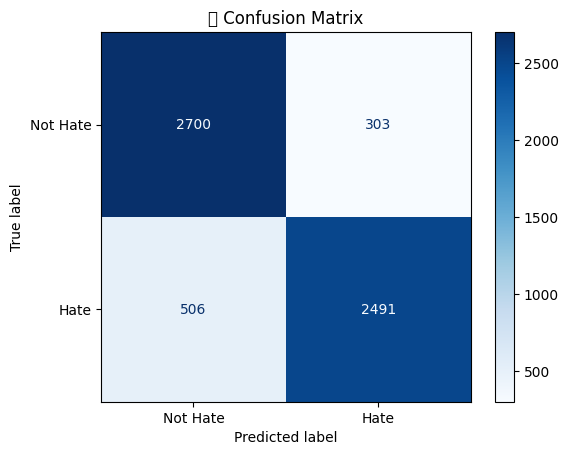

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix based on y_pred
cm = confusion_matrix(y_test, y_pred) # Changed y_pred_labels to y_pred

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("📊 Confusion Matrix")
plt.show()

#**Step 12 : Classification Report**

In [39]:
from sklearn.metrics import classification_report

# Use the same predictions
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Hate", "Hate"]))


📄 Classification Report:
              precision    recall  f1-score   support

    Not Hate       0.91      0.92      0.92      3000
        Hate       0.92      0.91      0.91      3000

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.91      6000
weighted avg       0.92      0.92      0.91      6000



In [38]:
# ✅ CODE 2: Raw Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n🔍 Raw Metrics:")
print("Accuracy =", acc)
print("Precision =", prec)
print("Recall =", rec)
print("F1-score =", f1)


🔍 Raw Metrics:
Accuracy = 0.915
Precision = 0.9191919191919192
Recall = 0.91
F1-score = 0.914572864321608


#**Step 12 : Model Training Performance Visualization**

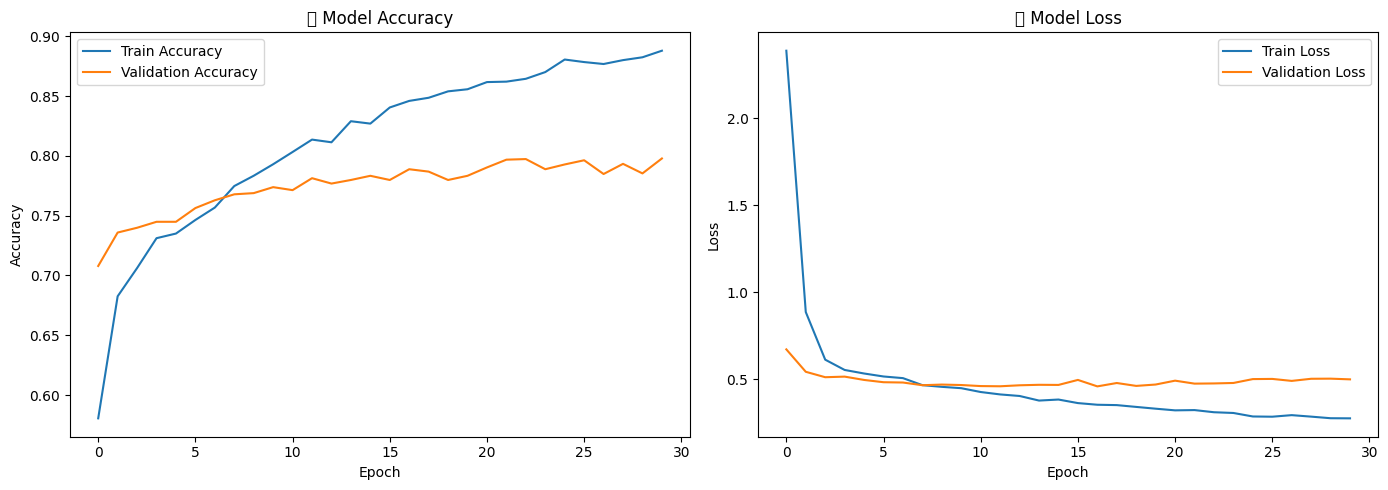

In [19]:
import matplotlib.pyplot as plt

# Check if training history exists
if 'history' in globals():
    # Create figure
    plt.figure(figsize=(14, 5))

    # 📈 Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('📈 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 📉 Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('📉 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
